<a href="https://colab.research.google.com/github/kaicong12/age-prediction/blob/main/colab/BN4101_Imputed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 11.3 MB/s eta 0:00:00


In [ ]:
# Tree based predictors
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import shap


# FC layer predictors
from tensorflow import keras
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


# Utils package
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('/content/master1.csv')

# replace infinite or NaN values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()


# rename dataframe from r
name_map = {
    'Total.time..numeric.trail.': 'Total time (numeric trail)',
    'Total.time..alphanumeric.trail.': 'Total time (alphanumeric trail)',
    'Total.error..numeric.path.': 'Total error (numeric path)',
    'Total.error..alphanumeric.path.': 'Total error (alphanumeric path)',
    'Mean.Completion.Time': 'Mean Completion Time',
    'Symbol.Digit.Substitution.Accuracy': 'Symbol Digit Substitution Accuracy',
    'Pair.Matching.Accuracy': 'Pair Matching Accuracy',
    'Maximum.digits.remembered.correctly': 'Maximum digits remembered correctly'
}
data.rename(columns=name_map, inplace=True)

cols_to_normalize = [
    'Total time (numeric trail)', 'Total time (alphanumeric trail)', 
    'Total error (numeric path)', 'Total error (alphanumeric path)', 
    'Mean Completion Time', 'FI_score', 
    'Symbol Digit Substitution Accuracy', 'Pair Matching Accuracy'
]

# do not have to normalize categorical columns
# convert them to integer instead, resembles one-hot encoding
categorical_columns = [
    'gender', 'Maximum digits remembered correctly'
]

numerical_data = data[cols_to_normalize]
categorical_data = data[categorical_columns].astype(int)


# convert FI score data to integer


numerical_data = (numerical_data-numerical_data.mean())/numerical_data.std()
X = pd.concat([numerical_data, categorical_data], axis=1)
y = data['age']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Baseline Linear Regression

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Baseline RMSE
y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Baseline RMSE: ", rmse)

Baseline RMSE:  7.1289989298875875


Exact explainer: 9276it [02:50, 51.45it/s]                          


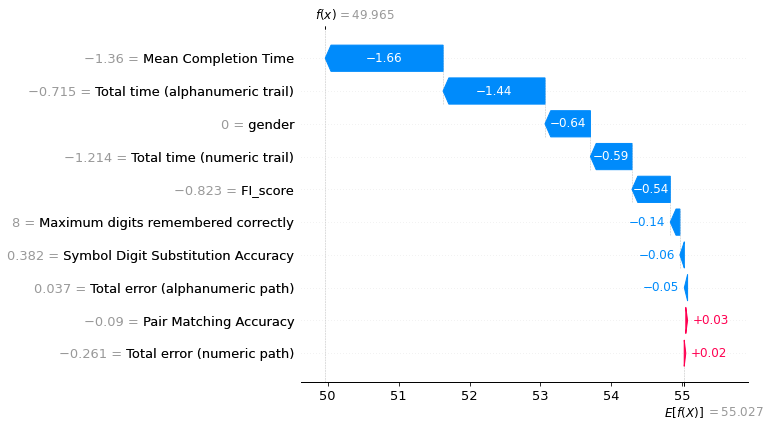

In [ ]:
# # SHAP explainer
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution
explainer = shap.Explainer(linear_model.predict, X100)
shap_values = explainer(X_test)

sample_ind = 20
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

# Tree based predictions

In [ ]:
def evaluate_tree(model):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model.__class__.__name__} Baseline RMSE: ", rmse)

In [ ]:
# Decision Tree
dt = DecisionTreeRegressor(random_state=0)
evaluate_tree(dt)


# Random Forest
rf = RandomForestRegressor(random_state=0)
evaluate_tree(rf)


# Boosted Tree
xgb = XGBRegressor()
evaluate_tree(xgb)

DecisionTreeRegressor Baseline RMSE:  9.962014899719362
RandomForestRegressor Baseline RMSE:  7.114675455817503
[01:39:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor Baseline RMSE:  6.9551147433494345


Exact explainer: 9276it [2:29:41,  1.03it/s]


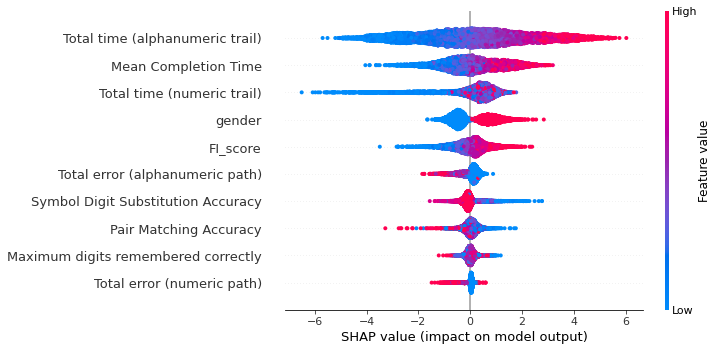

In [ ]:
# explain the tree model with SHAP
explainer_rf = shap.Explainer(rf.predict, X100)
shap_values_rf = explainer_rf(X_test)
shap.plots.beeswarm(shap_values_rf)

Exact explainer: 9276it [03:02, 47.93it/s]                          


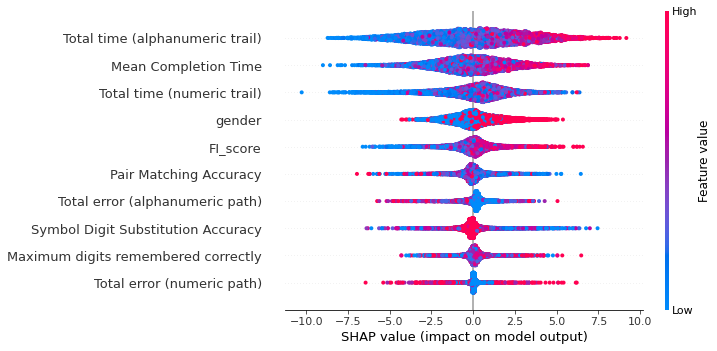

In [ ]:
# explain the tree model with SHAP
explainer_dt = shap.Explainer(dt.predict, X100)
shap_values_dt = explainer_dt(X_test)
shap.plots.beeswarm(shap_values_dt)

Exact explainer: 9276it [35:37,  4.32it/s]


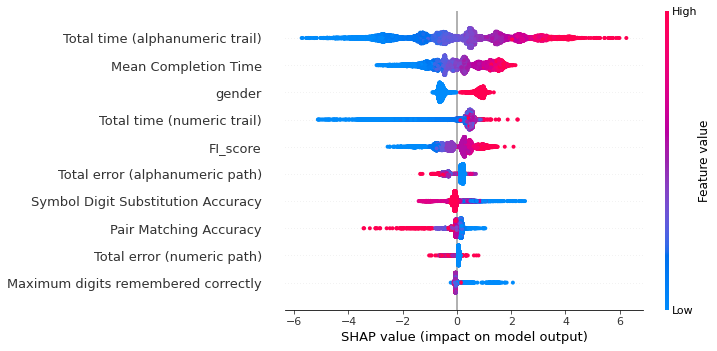

In [ ]:
# explain the tree model with SHAP
explainer_xgb = shap.Explainer(xgb.predict, X100)
shap_values_xgb = explainer_xgb(X_test)
shap.plots.beeswarm(shap_values_xgb)

# Hyperparameter Tuning

In [ ]:
def hyperparam_tuning(param_space, model):
    clf = RandomizedSearchCV(
        estimator = model, param_distributions = param_space, 
        n_iter=10, verbose=2, random_state=0, n_jobs = -1
    )
    # Fit the random search model
    clf.fit(X_train, y_train)

    print(f"Best params from {model.__class__.__name__} are ", clf.best_params_)

    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f'{model.__class__.__name__} Best RMSE = {round(rmse, 2)}.')

In [ ]:
# Decision Tree random grid
params = {
    "max_depth": [1,3,5,7,9,11,12],
    "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10],
    "min_weight_fraction_leaf": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    "max_leaf_nodes": [10,20,30,40,50,60,70,80,90]
}

dt = DecisionTreeRegressor(random_state = 0)
hyperparam_tuning(params, dt)


# Random Forest random grid
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]

# random_grid = {
#     'n_estimators': n_estimators,
#     'max_depth': max_depth,
#     'min_samples_split': min_samples_split,
#     'min_samples_leaf': min_samples_leaf
# }

# rf = RandomForestRegressor()
# hyperparam_tuning(random_grid, rf)


# XGB random grid
params = { 
    'max_depth': [3, 5, 6, 10, 15, 20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.4, 1.0, 0.1),
    "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10],
    "min_weight_fraction_leaf": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    # 'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
}

xgbr = XGBRegressor(seed = 0)
hyperparam_tuning(params, xgbr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params from DecisionTreeRegressor are  {'min_weight_fraction_leaf': 0.4, 'min_samples_leaf': 6, 'max_leaf_nodes': 30, 'max_depth': 9}
DecisionTreeRegressor Best RMSE = 7.4.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[01:44:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best params from XGBRegressor are  {'subsample': 0.7999999999999999, 'min_weight_fraction_leaf': 0.6, 'min_samples_leaf': 8, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999}
XGBRegressor Best RMSE = 6.96.


# FC layers Predictions

In [ ]:
fc_model = keras.Sequential()
fc_model.add(keras.layers.Dense(100, activation="relu"))
fc_model.add(keras.layers.Dense(50, activation="relu"))
fc_model.add(keras.layers.Dense(1))
fc_model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=[keras.metrics.mae]
)

In [ ]:
EPOCHS = 20
BATCH = 128

early_stopping = keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=5)

history = fc_model.fit(
    X_train, y_train,
    batch_size=BATCH,
    epochs=EPOCHS,
    shuffle=True,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/20
148/148 [==============================] - 6s 9ms/step - loss: 1134.0732 - mean_absolute_error: 27.5952 - val_loss: 130.7916 - val_mean_absolute_error: 9.0518
Epoch 2/20
148/148 [==============================] - 1s 7ms/step - loss: 126.2670 - mean_absolute_error: 8.8476 - val_loss: 117.5596 - val_mean_absolute_error: 8.5937
Epoch 3/20
148/148 [==============================] - 1s 7ms/step - loss: 110.2854 - mean_absolute_error: 8.3154 - val_loss: 99.7676 - val_mean_absolute_error: 7.9643
Epoch 4/20
148/148 [==============================] - 1s 8ms/step - loss: 90.2368 - mean_absolute_error: 7.5864 - val_loss: 79.6498 - val_mean_absolute_error: 7.1872
Epoch 5/20
148/148 [==============================] - 1s 9ms/step - loss: 69.5601 - mean_absolute_error: 6.7523 - val_loss: 60.6013 - val_mean_absolute_error: 6.4019
Epoch 6/20
148/148 [==============================] - 1s 8ms/step - loss: 55.2314 - mean_absolute_error: 6.1240 - val_loss: 51.9490 - val_mean_absolute_error: 5.95

In [ ]:
# Deep explainer does not work for Keras model
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

e = shap.DeepExplainer(fc_model, X100)
shap_values = e(X_test.iloc[51:100,:])
shap.plots.beeswarm(shap_values)

2973                     2.076477                         0.252555   
11732                    0.642623                         1.303573   
10694                    0.103975                        -0.094345   
21391                   -0.958160                        -0.783098   
14252                   -0.732375                        -0.797748   
...                           ...                              ...   
7729                    -0.707573                        -0.663177   
18984                   -0.993847                        -1.242550   
15564                   -0.023457                        -0.153926   
5728                     0.648532                        -0.371481   
7626                     0.625440                        -0.182108   

       Total error (numeric path)  Total error (alphanumeric path)  \
2973                    -0.260575                         0.456213   
11732                    0.253839                        -0.381432   
10694              

AttributeError: ignored

31/31 [==============================] - 0s 1ms/step


Exact explainer:   6%|▌         | 3/49 [00:00<?, ?it/s]

34/34 [==============================] - 0s 1ms/step


Exact explainer:  10%|█         | 5/49 [00:16<01:55,  2.64s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  12%|█▏        | 6/49 [00:19<02:09,  3.02s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 7/49 [00:24<02:26,  3.49s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  16%|█▋        | 8/49 [00:27<02:25,  3.54s/it]

34/34 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 9/49 [00:31<02:26,  3.67s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 10/49 [00:35<02:23,  3.67s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  22%|██▏       | 11/49 [00:40<02:38,  4.18s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 12/49 [00:44<02:25,  3.95s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 13/49 [00:47<02:20,  3.91s/it]

34/34 [==============================] - 0s 1ms/step


Exact explainer:  29%|██▊       | 14/49 [00:52<02:19,  3.99s/it]

34/34 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 15/49 [00:57<02:29,  4.38s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  33%|███▎      | 16/49 [01:02<02:33,  4.66s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  35%|███▍      | 17/49 [01:07<02:26,  4.59s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  37%|███▋      | 18/49 [01:10<02:12,  4.26s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  39%|███▉      | 19/49 [01:15<02:17,  4.57s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 20/49 [01:53<07:00, 14.50s/it]

34/34 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 21/49 [01:58<05:28, 11.74s/it]

34/34 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 22/49 [02:04<04:25,  9.82s/it]

34/34 [==============================] - 0s 1ms/step


Exact explainer:  47%|████▋     | 23/49 [02:08<03:29,  8.04s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  49%|████▉     | 24/49 [02:11<02:49,  6.77s/it]

34/34 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 25/49 [02:17<02:31,  6.33s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  53%|█████▎    | 26/49 [02:21<02:11,  5.71s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  55%|█████▌    | 27/49 [02:26<02:02,  5.58s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  57%|█████▋    | 28/49 [02:32<01:55,  5.49s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  59%|█████▉    | 29/49 [02:35<01:39,  4.97s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  61%|██████    | 30/49 [02:39<01:27,  4.61s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  63%|██████▎   | 31/49 [02:43<01:17,  4.31s/it]

34/34 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 32/49 [02:48<01:19,  4.67s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  67%|██████▋   | 33/49 [02:53<01:17,  4.85s/it]

34/34 [==============================] - 0s 1ms/step


Exact explainer:  69%|██████▉   | 34/49 [02:59<01:14,  4.98s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  71%|███████▏  | 35/49 [03:03<01:06,  4.75s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  73%|███████▎  | 36/49 [03:08<01:03,  4.91s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  76%|███████▌  | 37/49 [03:14<01:00,  5.02s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  78%|███████▊  | 38/49 [03:19<00:56,  5.12s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  80%|███████▉  | 39/49 [03:24<00:51,  5.19s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  82%|████████▏ | 40/49 [03:30<00:46,  5.22s/it]

34/34 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▎ | 41/49 [03:34<00:39,  4.90s/it]

34/34 [==============================] - 0s 1ms/step


Exact explainer:  86%|████████▌ | 42/49 [03:39<00:35,  5.04s/it]

34/34 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 43/49 [03:44<00:30,  5.12s/it]

34/34 [==============================] - 0s 1ms/step


Exact explainer:  90%|████████▉ | 44/49 [03:48<00:24,  4.83s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 45/49 [03:54<00:19,  4.99s/it]

34/34 [==============================] - 0s 1ms/step


Exact explainer:  94%|█████████▍| 46/49 [03:59<00:15,  5.08s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 47/49 [04:03<00:09,  4.86s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  98%|█████████▊| 48/49 [04:09<00:04,  4.99s/it]

31/31 [==============================] - 0s 1ms/step


Exact explainer: 100%|██████████| 49/49 [04:12<00:00,  4.53s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer: 50it [04:18,  5.49s/it]


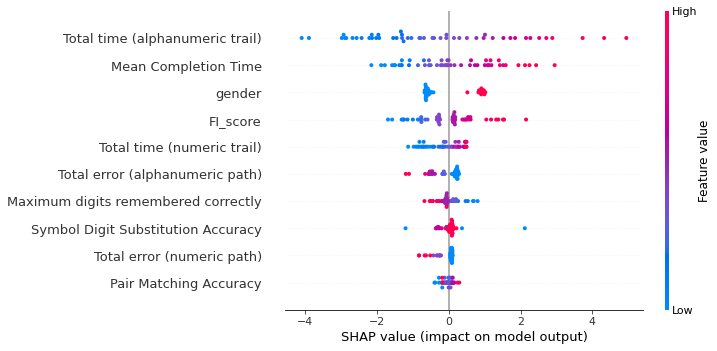

In [ ]:
# explain the tree model with SHAP
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

explainer_nn = shap.Explainer(fc_model.predict, X100)
shap_values_nn = explainer_nn(X_test.iloc[51:100, :])
shap.plots.beeswarm(shap_values_nn)

# Pytorch Implementation

In [ ]:
class Net(nn.Module):
    def __init__(self, num_features):
        super(Net, self).__init__()

        num_features = num_features
        self.fc1 = nn.Linear(num_features, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        # x = F.relu(self.fc1(x))
        x = self.fc1(x)

        return x

In [ ]:
class BiobankDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()

        return [torch.tensor(self.X.iloc[idx].values).type(torch.LongTensor), self.y[idx]]

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    print(epoch, "this is epoch")
    for batch_idx, (data, target) in enumerate(train_loader):
        print("entered")
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


train_set = BiobankDataset(X_train.astype("float32"), y_train)
test_set = BiobankDataset(X_test.astype("float32"), y_test)

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)

In [ ]:
EPOCHS = 20
device = torch.device("cpu")

if torch.cuda.is_available():
   print("Training on GPU")
   device = torch.device("cuda:0")

num_features = X_train.shape[1]
model = Net(num_features).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, EPOCHS + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

1 this is epoch
entered


RuntimeError: ignored

# Repeated analysis for imputed dataset

In [ ]:
def read_data(path):
    data = pd.read_csv(path)

    # replace infinite or NaN values
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data = data.dropna()


    # rename dataframe from r
    name_map = {
        'Total.time..numeric.trail.': 'Total time (numeric trail)',
        'Total.time..alphanumeric.trail.': 'Total time (alphanumeric trail)',
        'Total.error..numeric.path.': 'Total error (numeric path)',
        'Total.error..alphanumeric.path.': 'Total error (alphanumeric path)',
        'Mean.Completion.Time': 'Mean Completion Time',
        'Symbol.Digit.Substitution.Accuracy': 'Symbol Digit Substitution Accuracy',
        'Pair.Matching.Accuracy': 'Pair Matching Accuracy',
        'Maximum.digits.remembered.correctly': 'Maximum digits remembered correctly'
    }
    data.rename(columns=name_map, inplace=True)

    cols_to_normalize = [
        'Total time (numeric trail)', 'Total time (alphanumeric trail)', 
        'Total error (numeric path)', 'Total error (alphanumeric path)', 
        'Mean Completion Time', 'FI_score', 
        'Symbol Digit Substitution Accuracy', 'Pair Matching Accuracy'
    ]

    # do not have to normalize categorical columns
    # convert them to integer instead, resembles one-hot encoding
    categorical_columns = [
        'gender', 'Maximum digits remembered correctly'
    ]

    numerical_data = data[cols_to_normalize]
    categorical_data = data[categorical_columns].astype(int)


    # convert FI score data to integer


    numerical_data = (numerical_data-numerical_data.mean())/numerical_data.std()
    X = pd.concat([numerical_data, categorical_data], axis=1)
    y = data['age']

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    return X_train, X_test, y_train, y_test


def evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    return rmse

def tune(param_space, model):
    clf = RandomizedSearchCV(
        estimator = model, param_distributions = param_space, 
        n_iter=10, verbose=2, random_state=0, n_jobs = -1
    )
    # Fit the random search model
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    return clf.best_params_, rmse

In [ ]:
def main():
    EPOCHS = 20
    BATCH = 128

    pd_data = {
        'dataset': [],
        'dt_rmse': [],
        'rf_rmse': [],
        'xgb_rmse': [],
        'dt_best_params': [],
        'dt_tune_rmse': [],
        'rf_best_params': [],
        'rf_tune_rmse': [],
        'xgb_best_params': [],
        'xgb_tune_rmse': [],
        'history': []
    }

    for i in range(1, 6):
        pd_data['dataset'].append(i)
        X_train, X_test, y_train, y_test = read_data(f'/content/master{i}.csv')

        # Decision Tree
        dt = DecisionTreeRegressor(random_state=0)
        dt_rmse = evaluate(dt, X_train, X_test, y_train, y_test)
        pd_data['dt_rmse'].append(dt_rmse)


        # Random Forest
        rf = RandomForestRegressor(random_state=0)
        rf_rmse = evaluate(rf, X_train, X_test, y_train, y_test)
        pd_data['rf_rmse'].append(rf_rmse)


        # Boosted Tree
        xgb = XGBRegressor()
        xgb_rmse = evaluate(xgb, X_train, X_test, y_train, y_test)
        pd_data['xgb_rmse'].append(xgb_rmse)

        # Decision Tree random grid
        params = {
            "max_depth": [1,3,5,7,9,11,12],
            "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10],
            "min_weight_fraction_leaf": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
            "max_leaf_nodes": [10,20,30,40,50,60,70,80,90]
        }

        dt = DecisionTreeRegressor(random_state = 0)
        dt_best_params, dt_tune_rmse = tune(params, dt)
        pd_data['dt_best_params'].append(dt_best_params)
        pd_data['dt_tune_rmse'].append(dt_tune_rmse)


        # Random Forest random grid
        n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        min_samples_split = [2, 5, 10]
        min_samples_leaf = [1, 2, 4]

        random_grid = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf
        }

        rf = RandomForestRegressor()
        rf_best_params, rf_tune_rmse = tune(params, rf)
        pd_data['rf_best_params'].append(rf_best_params)
        pd_data['rf_tune_rmse'].append(rf_tune_rmse)


        # XGB random grid
        params = { 
            'max_depth': [3, 5, 6, 10, 15, 20],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'subsample': np.arange(0.5, 1.0, 0.1),
            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
            "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10],
            "min_weight_fraction_leaf": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
            # 'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
        }

        xgbr = XGBRegressor(seed = 0)
        xgb_best_params, xgb_tune_rmse = tune(params, xgb)
        pd_data['xgb_best_params'].append(xgb_best_params)
        pd_data['xgb_tune_rmse'].append(xgb_tune_rmse)


        fc_model = keras.Sequential()
        fc_model.add(keras.layers.Dense(100, activation="relu"))
        fc_model.add(keras.layers.Dense(50, activation="relu"))
        fc_model.add(keras.layers.Dense(1))
        fc_model.compile(
            loss="mean_squared_error",
            optimizer=keras.optimizers.Adam(lr=0.001),
            metrics=[keras.metrics.mae]
        )

        early_stopping = keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=5)

        history = fc_model.fit(
            X_train, y_train,
            batch_size=BATCH,
            epochs=EPOCHS,
            shuffle=True,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping]
        )
        pd_data['history'].append(history)

    return pd_data

In [ ]:
results = main()
pd.DataFrame(results)

[02:38:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[02:43:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Epoch 1/20
542/542 [==============================] - 3s 4ms/step - loss: 402.0877 - mean_absolute_error: 13.8344 - val_loss: 92.0096 - val_mean_absolute_error: 7.6055
Epoch 2/20
542/542 [==============================] - 2s 4ms/step - loss: 61.4789 - mean_absolute_error: 6.3980 - val_loss: 51.8257 - val_mean_absolute_error: 5.9449
Epoch 3/20
542/542 [==============================] - 2s 4ms/step - loss: 50.4160 - mean_absolute_error: 5.8809 - val_loss: 51.7080 - val_mean_absolute_error: 6.0454
Epoch 4/20
542/542 [==============================] - 2s 4ms/st

,dataset,dt_rmse,rf_rmse,xgb_rmse,dt_best_params,dt_tune_rmse,rf_best_params,rf_tune_rmse,xgb_best_params,xgb_tune_rmse,history
0,1,9.962015,7.114675,6.955115,"{'min_weight_fraction_leaf': 0.4, 'min_samples...",7.397229,"{'min_weight_fraction_leaf': 0.4, 'min_samples...",7.383944,"{'subsample': 0.7999999999999999, 'min_weight_...",6.957428,<keras.callbacks.History object at 0x7fa901711...
1,2,10.044075,7.119985,6.957605,"{'min_weight_fraction_leaf': 0.4, 'min_samples...",7.397229,"{'min_weight_fraction_leaf': 0.4, 'min_samples...",7.382826,"{'subsample': 0.7999999999999999, 'min_weight_...",6.957428,<keras.callbacks.History object at 0x7fa92e0ef...
2,3,9.978632,7.122517,6.960736,"{'min_weight_fraction_leaf': 0.4, 'min_samples...",7.397229,"{'min_weight_fraction_leaf': 0.4, 'min_samples...",7.382190,"{'subsample': 0.7999999999999999, 'min_weight_...",6.957428,<keras.callbacks.History object at 0x7fa902c13...
3,4,10.008510,7.130293,6.962498,"{'min_weight_fraction_leaf': 0.4, 'min_samples...",7.397229,"{'min_weight_fraction_leaf': 0.4, 'min_samples...",7.380369,"{'subsample': 0.7999999999999999, 'min_weight_...",6.957428,<keras.callbacks.History object at 0x7fa902dd7...
4,5,9.981827,7.121327,6.962319,"{'min_weight_fraction_leaf': 0.4, 'min_samples...",7.397229,"{'min_weight_fraction_leaf': 0.4, 'min_samples...",7.383621,"{'subsample': 0.7999999999999999, 'min_weight_...",6.957428,<keras.callbacks.History object at 0x7fa902e95...
